# Self Organizing Maps

# Sommaire


* ##   [Import](#S1)

* ##   [Definitions](#S2)

* ##   [Colors](#S3)
> ### [First visualization](#S3_1)
> ### [Errors](#S3_4)
> ### [Interactive SOMs](#S3_2)
> ### [Tests hyperparameters](#S3_3)

* ##   [COSMOS](#S4)


* ##   [True Universe](#S5)

<a name="S1"></a>
# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ipywidgets import (interactive, 
                        IntSlider,
                        FloatSlider,
                        fixed, 
                        Label,
                        Checkbox,
                        Layout
                        )

In [3]:
from hyperopt import (fmin, 
                      tpe, 
                      hp, 
                      Trials, 
                      STATUS_OK)

In [ ]:
!pip install minisom

In [5]:
from minisom import MiniSom

[minisom](https://github.com/JustGlowing/minisom/tree/35e32cf4adeceb807d699c27c044c709c7ca4e3c) and [GHSOM](https://github.com/enry12/growing_hierarchical_som) on github

In [9]:
cd growing_hierarchical_som

/content/drive/My Drive/Colab Notebooks/growing_hierarchical_som


In [10]:
from GHSOM import GHSOM

In [11]:
cd ..

/content/drive/My Drive/Colab Notebooks


Loading Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


<a name="S2"></a>
# Main definitions

## Training

In [12]:
def train_som(data, sigma, learning_rate, iterations, 
              verbose=False, topology='rectangular', size='default'):
    
    rows, cols = data.shape

    if size=='default':
        som_x = int(np.sqrt(5*np.sqrt(rows)))
        som_y = som_x
    elif size=='input':
        som_x = int(input("SOMs x :"))
        som_y = int(input("SOMs y :"))
    else:
        try:
            som_x, som_y = size
        except:
            raise ValueError("wrong input for -size-")

    som = MiniSom(som_x, som_y,
                  input_len = cols,
                  sigma = sigma,
                  learning_rate = learning_rate,
                  topology = topology)
    
    #som.random_weights_init(data)

    som.train_random(data, iterations, verbose=verbose)

    weights = som.get_weights()

    return som, weights

### Manual training

In [13]:
def train_and_get_error(X_train, X_test, 
                        sigma, learning_rate, 
                        iterations, frequence, 
                        topological_error=False, get_res=False, animated=True):
    
    rows, cols = X_train.shape
    som_x = int(np.sqrt(5*np.sqrt(rows)))
    som_y = som_x


    som = MiniSom(som_x, som_y, cols, sigma, learning_rate)

    som.random_weights_init(X_train)

    q_error = [] ; t_error = []
    q_error_val = []
    iter_x = []
    mapmean = []

    if animated:
        from IPython.display import clear_output

    for i in range(iterations):
        rand_i = np.random.randint(len(X_train)) # This corresponds to train_random() method.
        som.update(X_train[rand_i], som.winner(X_train[rand_i]), i, iterations)
        
        if (i+1) % frequence == 0:
            q_error.append(som.quantization_error(X_train)) # loss
            q_error_val.append(som.quantization_error(X_test)) # val_loss
            if topological_error:
                t_error.append(som.topographic_error(X_train)) # topo. error
            iter_x.append(i) # iter 
            mapmean.append(np.mean(som.distance_map())) # distance map mean

            if not animated:
                print('\r [ %d / %d ] ; %d %%'%(i+1, iterations, 100*(i+1)/iterations), end='')

            if animated: # show weights and distance map during the training
                fig, ax = plt.subplots(1, 2, figsize=(14,7))
                
                ax[0].imshow(som.get_weights())
                ax[1].imshow(som.distance_map())
                ax[1].set_title('distance map ; mean = %.2f' % mapmean[-1])

                plt.suptitle('[ %d / %d ] ; %d %%'%(i+1, iterations, 100*(i+1)/iterations))
                plt.show()
                clear_output(wait=True)
            
    weights = som.get_weights()

    if get_res:
        return som, weights, iter_x, q_error, q_error_val, t_error, mapmean

---

## Subplots

### Subplots rectangles

In [14]:
# subplots with : the SOMs, the distance map, the variables weights and other

def som_color(data, som, weights, var_names=(["R","G","B"]), activation=False):
    rows, cols = data.shape
    som_x, som_y = weights.shape[:2]

    assert cols>1, 'Not enought variables, need at least 2'


    fig, ax = plt.subplots(nrows=2, ncols=cols, figsize=(14,10))

    # SOMs
    ax[0,0].set_title('SOMs '+str(som_x)+' x '+str(som_y))
    if cols<3: # if data shape == 2, adding a dimension to the imshow
        cube  = np.zeros((som_x,som_y,3))
        for i in range(cols):
            cube[:,:,i] = weights[:,:,i]
        ax[0,0].imshow(cube)
    elif cols<5 and cols>2:
        ax[0,0].imshow(weights)
    else:
        print("Can't show a %dD matrix "%(cols))
        print("-----------------------\n")


    # distance map
    ax[0,1].set_title('distance map ; mean = %.2f' % np.mean(som.distance_map()))
    ax1 = ax[0,1].imshow(som.distance_map())


    # activation response
    if activation and cols>2:
        activ_resp = som.activation_response(data)
        
        # if hight values at the border are limiting the visualisation :
        if type(activation)==int:
            hight = np.where(activ_resp>(np.max(activ_resp)/activation))
            activ_resp[hight] /= activation
        
        ax[0,2].set_title('activation response')
        ax2 = ax[0,2].imshow(activ_resp)
        plt.colorbar(ax2,ax=ax[0,2])


    # variables plots
    for i in range(cols):
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass
        ax[1,i].imshow(weights[:,:,i])


    for i in range(2):
        for j in range(cols):
            ax[i,j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# example of use
"""
sigma = 9
learning_rate = 1
print("sigma = %.1f ; learning rate %.1f \n" % (sigma, learning_rate))

som, weights = train_som(data, sigma, learning_rate, 1000, verbose=False)

som_color(data, som, weights, vars_names)
"""

### Subplots hexagonal

In [15]:
def som_hexa(data, som, weights, var_names, useless_var=False):
    rows, cols = data.shape
    som_x, som_y = weights.shape[:2]

    assert cols>1, 'Not enought variables, need at least 2'

    from matplotlib.patches import RegularPolygon
    from matplotlib.colors import to_hex

    fig, ax = plt.subplots(nrows=2, ncols=cols, figsize=(18,12))

    xx, yy = som.get_euclidean_coordinates()
    wy = yy*np.sqrt(3)/2
    umatrix = som.distance_map()

    for i in range(som_x):
        for j in range(som_y):
            
            if cols<5:
                # SOMs
                hex = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                    radius=.95/np.sqrt(3)+.03,
                                    facecolor=to_hex(weights[i, j]), lw=0)
                ax[0,0].add_patch(hex)

            # distance map
            hex1 = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                  radius=.95/np.sqrt(3)+.03,
                                  facecolor=plt.cm.viridis(umatrix[i, j]), lw=0)
            ax[0,1].add_patch(hex1)

            for k in range(cols): # each layer of the weights
                hexRGB = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                        radius=.95/np.sqrt(3)+.03,
                                        facecolor=plt.cm.viridis(weights[i, j, k]), lw=0)
                ax[1,k].add_patch(hexRGB)

    if cols>=5:
        print("Can't show a %dD matrix "%(cols))
        print("-----------------------\n")


    # limits and axis
    for i in range(2):
        for j in range(cols):
            ax[i,j].set_xticks(np.arange(som_x) - .5)
            ax[i,j].set_yticks(np.arange(som_y) *2 / np.sqrt(3)*3/4)
            ax[i,j].set_aspect('equal')
            ax[i,j].axis('off')
    
    # titles
    ax[0,0].set_title('SOMs '+str(som_x)+' x '+str(som_y))
    ax[0,1].set_title('distance map')
    for i in range(cols):
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass
    
    plt.tight_layout()
    plt.show()

In [ ]:
# example of use
"""
sigma = 9
learning_rate = 1
print("sigma = %.1f ; learning rate %.1f \n" % (sigma, learning_rate))

som, weights = train_som(data, sigma, learning_rate, 1000, verbose=False, topology='hexagonal')
som_hexa(data, som, weights, vars_names)
"""

### Error plots

In [16]:
def plot_error(iter_x, q_error, q_error_val, t_error, mapmean, topological_error=False):
    
    plt.figure(figsize=(10,4))
    plt.plot(iter_x, q_error, 'b--', label='loss')
    plt.plot(iter_x, q_error_val, 'go', label='val_loss')
    plt.ylabel('quantization error')
    plt.xlabel('iteration')
    plt.legend()
    
    if topological_error:
        plt.figure(figsize=(10,4))
        plt.plot(iter_x, t_error)
        plt.ylabel('topological error')
    
    plt.figure(figsize=(10,4))
    plt.plot(iter_x, mapmean)
    plt.ylabel('mean of the distance map')

    plt.show()

### Hitmap

In [17]:
def Hitmap(som, data, normed=True, figsize='default'):
    
    if len(data.shape)==1:
        print("adding a dimension to the input")
        data = np.vstack([data, np.zeros(len(data))]).T
    else:
        pass
    
    activ_resp = som.activation_response(data)

    if figsize=='default':
        plt.figure(figsize=(14,14))
    else:
        plt.figure(figsize=figsize)


    from matplotlib.colors import LogNorm

    if normed:
        norm = LogNorm()
    else:
        norm = None
    
    plt.imshow(activ_resp, norm = norm)


    som_x, som_y = som.get_weights().shape[:2]

    for i in range(som_x):
        for j in range(som_y):
            if activ_resp[i,j]!=0: # don't show inactivated cells

                # i,j inverted in plt.text because of the minisom's coordinates problem
                plt.text(j, i, int(activ_resp[i,j]), 
                         horizontalalignment='center',
                         verticalalignment='center')
                
    plt.tight_layout()
    #plt.colorbar()
    plt.show()

---

## Interactive SOMs



In [18]:
def interactive_som(data, names, 
                    sigma, learning_rate, iterations, 
                    activation, info, 
                    topology, def_topo):

    som, wts = train_som(data, 
                         sigma = sigma, 
                         learning_rate = learning_rate,
                         iterations = iterations,
                         topology = topology)
    
    def_topo(data, som, wts, names, activation)

    if info and topology=='rectangular':
        print('quantization error :', som.quantization_error(data))
        print('topographic error :', som.topographic_error(data))


def interactive_plot(data, rows, names, 
                     activation=False, infos=False, topology='rectangular'):

    som_x = int(np.sqrt(5*np.sqrt(rows)))
    som_y = som_x

    layout = Layout(width='40%', height='40px')

    if topology=='rectangular':
        def_topo=som_color
    elif topology=='hexagonal':
        def_topo=som_hexa
    else:
        raise ValueError("tolopogy should be 'rectangular or 'hexagonal', not "+topology)

    interact = interactive(interactive_som,
                           data = fixed(data),
                           names = fixed(names),
                           sigma = FloatSlider(min=1, 
                                               max=int(som_x/2.01), 
                                               step=0.2, 
                                               value=int(som_x/4),
                                               layout=layout),
                           learning_rate = FloatSlider(min=0.1, 
                                                       max=5, 
                                                       step=0.1, 
                                                       value=1,
                                                       layout=layout),
                           iterations = IntSlider(min=0, max=5000, step=20, value=500, layout=layout),
                           activation = fixed(activation),
                           info = fixed(infos),
                           topology=fixed(topology),
                           def_topo=fixed(def_topo))
    return interact

---

## Infos

In [ ]:
# informations on the min and max values of variables in a dataset

def info_min_max(dataset, names):
    for i in range(len(names)):
        print(names[i], '\n')
        try:
            print("Max", max(dataset[names[i]]))
            print("Min", min(dataset[names[i]]))
        except:
            for j in range( dataset[names[i]].shape[1] ):
                print("Max", max(dataset[names[i]][:,j]))
                print("Min", min(dataset[names[i]][:,j]))
                print("---------")
        print("\n-------------------------------\n")

<a name="S3"></a>
# Colors 

In [19]:
def dat_color(nb=25000, more_dim=0):
    dat1 = np.random.uniform(0,1,nb)
    dat2 = np.random.uniform(0,1,nb)
    dat3 = np.random.uniform(0,1,nb)

    data = np.vstack((dat1,dat2,dat3)).T

    if more_dim:
        for i in range(3,more_dim):
            np.random.shuffle(dat3)
            data = np.vstack((data.T, dat3)).T

    names = ['Red', 'Green', 'Blue']
    return nb, data, names

<a name="S3_1"></a>
## First visualization

In [14]:
nb, data_color, color_names = dat_color()
# nb<2e5 to see topological error

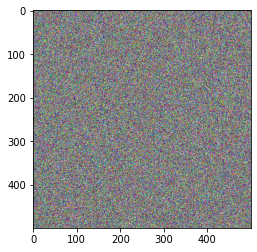

In [ ]:
plt.imshow(data_color.reshape(500,500,3));

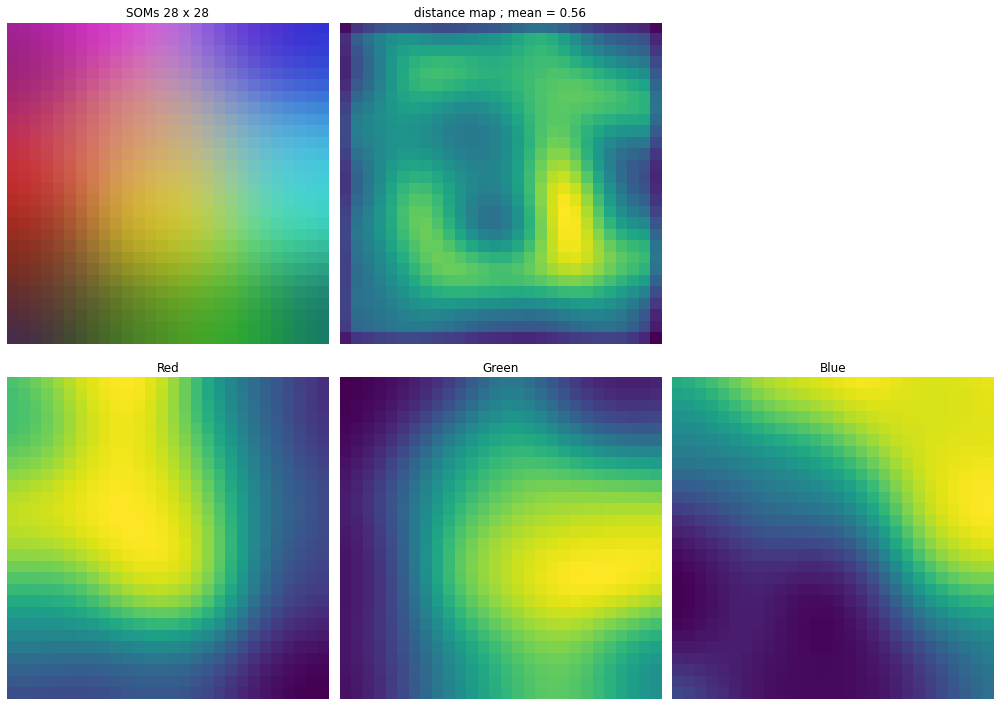

In [ ]:
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

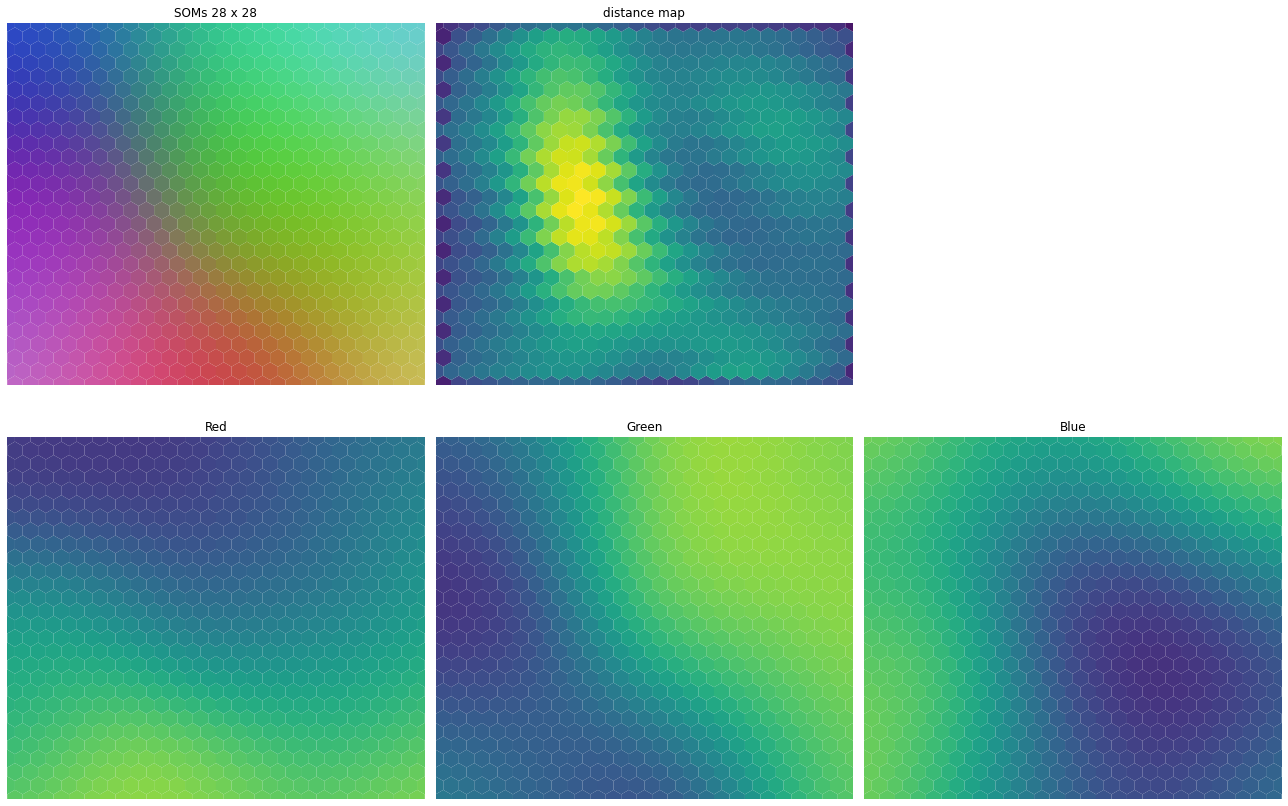

In [ ]:
sigma = 10
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000, topology='hexagonal')
som_hexa(data_color, som, weights, color_names)

### Weird result

sigma = 12.0 ; learning rate 1.0 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


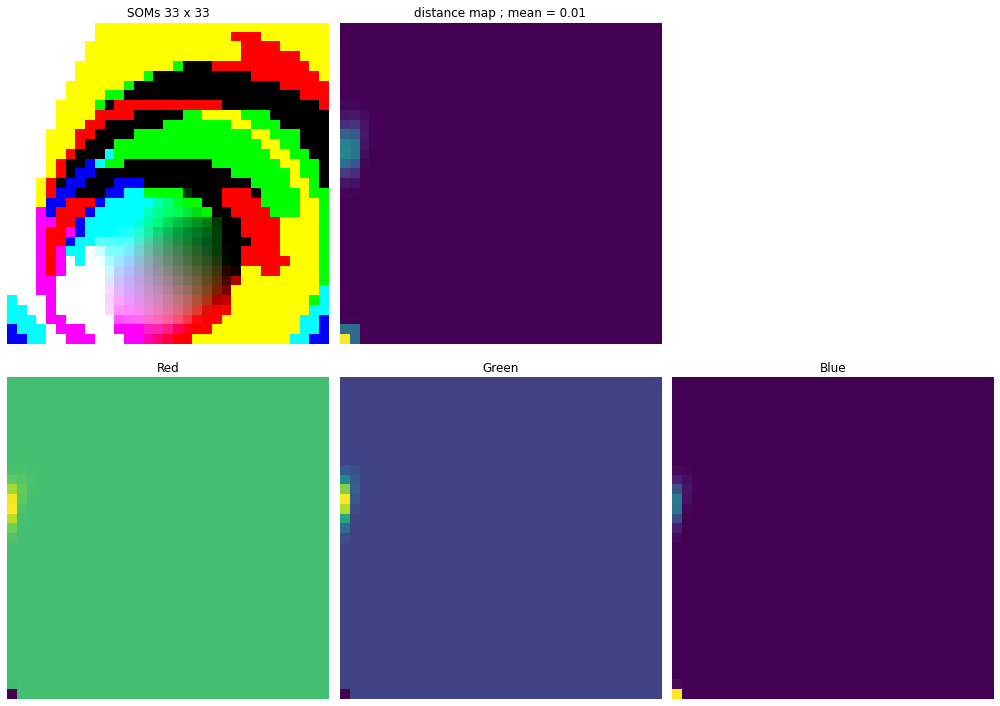

In [ ]:
sigma = 12
learning_rate = 1
print("sigma = %.1f ; learning rate %.1f \n" % (sigma, learning_rate))

som, weights = train_som(data_color, sigma, learning_rate, 1000)

som_color(data_color, som, weights, color_names)
# neighborhood function = bubble 

<a name="S3_4"></a>
## Errors

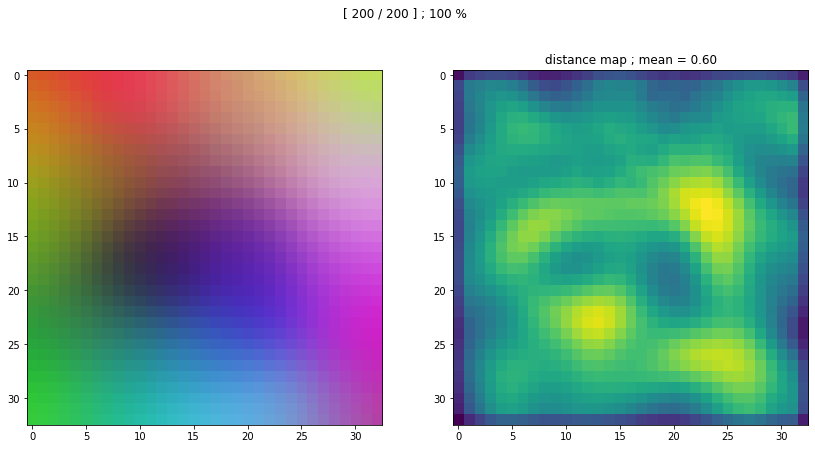

In [ ]:
nb, data_color, color_names = dat_color(nb=50000)
X_train, X_test = train_test_split(data_color, test_size=0.05)

sigma = 5
learning_rate = 0.5
iterations = 200
frequence = 5

som, weights, iter_x, q_error, q_error_val, t_error, mapmean = train_and_get_error(X_train, X_test, 
                                    sigma, learning_rate, 
                                    iterations, frequence, 
                                    topological_error=False, get_res=True)

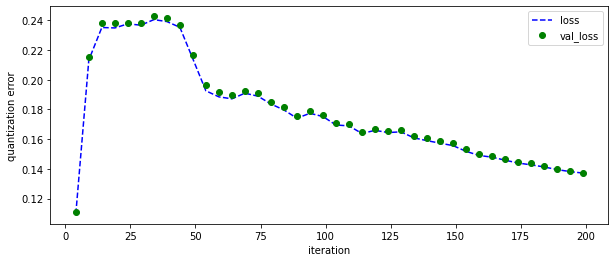

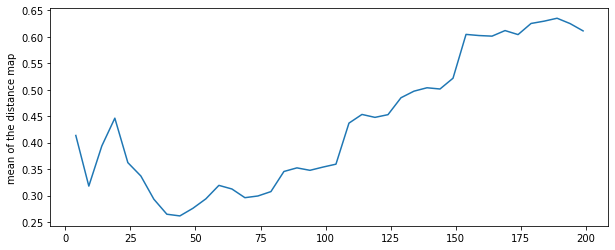

In [ ]:
plot_error(iter_x, q_error, q_error_val, t_error, mapmean)

<a name="S3_2"></a>
## Interactive SOMs

### Rectangular

In [ ]:
nb, data_color, color_names = dat_color(nb=25000)

In [ ]:
interactive_plot(data_color, nb, color_names)

interactive(children=(FloatSlider(value=7.0, description='sigma', layout=Layout(height='40px', width='40%'), m…

### Hexagonal

In [ ]:
nb, data_color, color_names = dat_color(nb=25000)

In [ ]:
interactive_plot(data_color, nb, color_names, topology='hexagonal')

interactive(children=(FloatSlider(value=7.0, description='sigma', layout=Layout(height='40px', width='40%'), m…

## Test hitmap

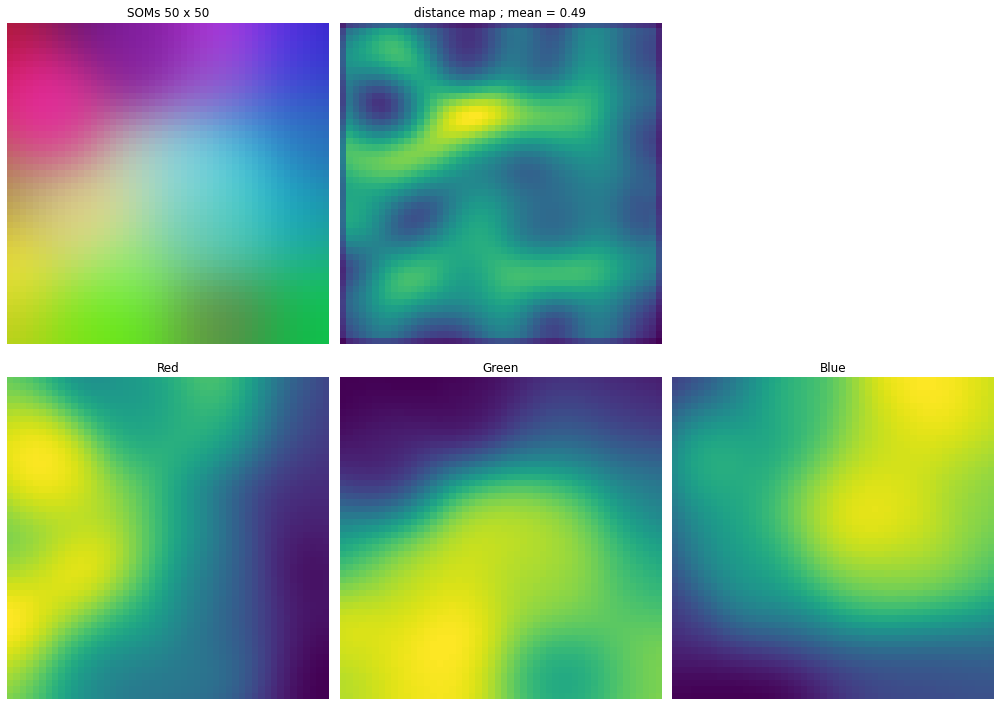

In [ ]:
nb, data_color, color_names = dat_color(nb=250000)

sigma = 9
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 100)
som_color(data_color, som, weights, color_names)

In [ ]:
NB = 25000
a = np.random.uniform(0,1,NB)
b = np.random.uniform(0,1,NB)
c = np.random.normal(.8,.05,NB)

#a = np.random.uniform(0,.01,NB)
#b = np.random.uniform(0,.01,NB)
#c = np.random.uniform(0,1,NB)
c /= max(c)

abc = np.vstack([a,b,c]).T

#plt.imshow(abc.reshape(500,500,3));

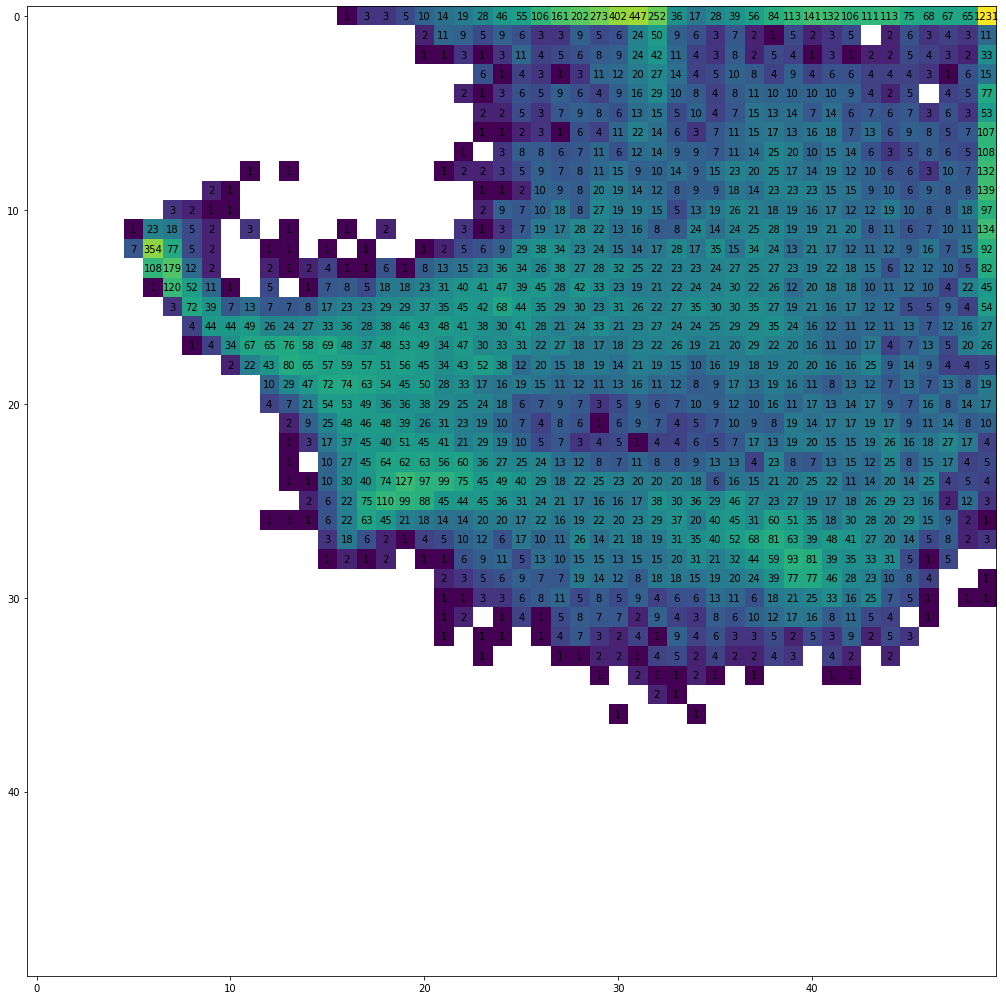

In [ ]:
Hitmap(som, abc) # abc -> dataset fortement bleu -> hitmap tres proche de blue_weights

### Coord inverted example

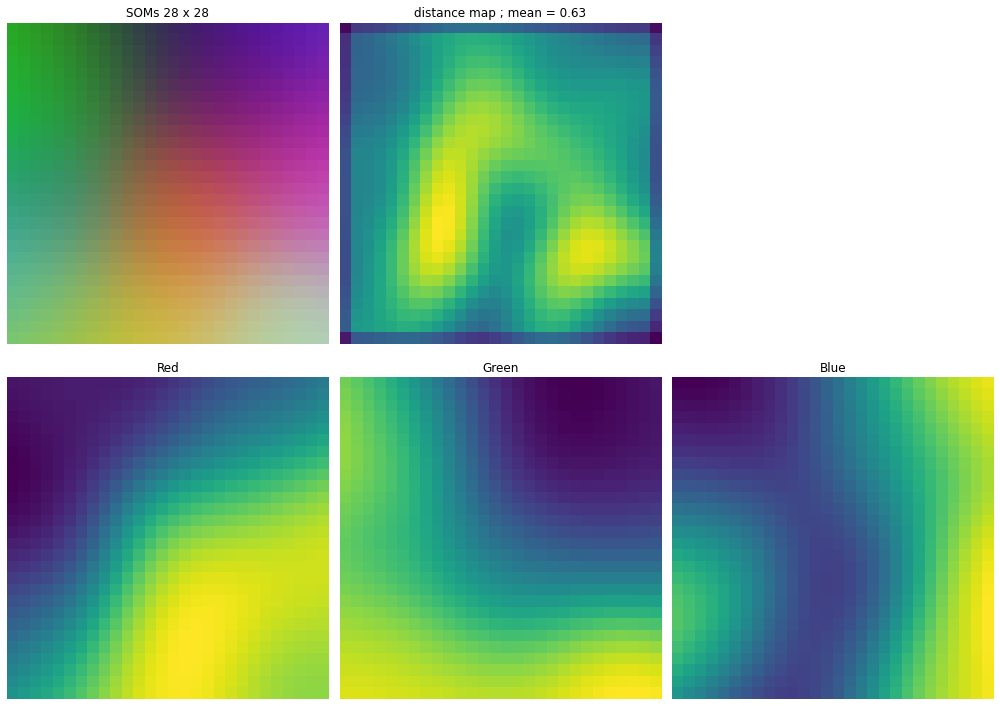

In [ ]:
nb, data_color, color_names = dat_color()

sigma = 9
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 1000)
som_color(data_color, som, weights, color_names)

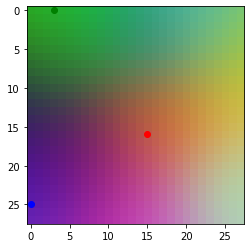

In [ ]:
w3 = weights.copy()
for i in range(3):
    w3[:,:,i]=w3[:,:,i].T

plt.imshow(w3)

r,g,b = [[1,0,0], [0,1,0], [0,0,1]]

plt.scatter(*som.winner(r), color='red')
plt.scatter(*som.winner(g), color='green')
plt.scatter(*som.winner(b), color='blue');

In [ ]:
som.winner(g)

(3, 0)

(array([3]), array([0]))


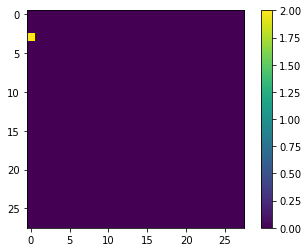

In [ ]:
print(np.where(som.activation_response([g,g])))

plt.imshow(som.activation_response([g,g]))
plt.colorbar();

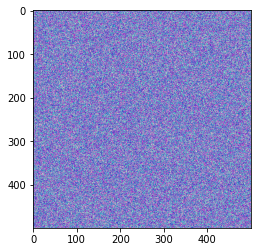

In [ ]:
NB = 250000
a = np.random.uniform(0,1,NB)
b = np.random.uniform(0,1,NB)
c = np.random.normal(.8,.05,NB)
c /= max(c)

abc = np.vstack([a,b,c]).T

plt.imshow(abc.reshape(500,500,3));

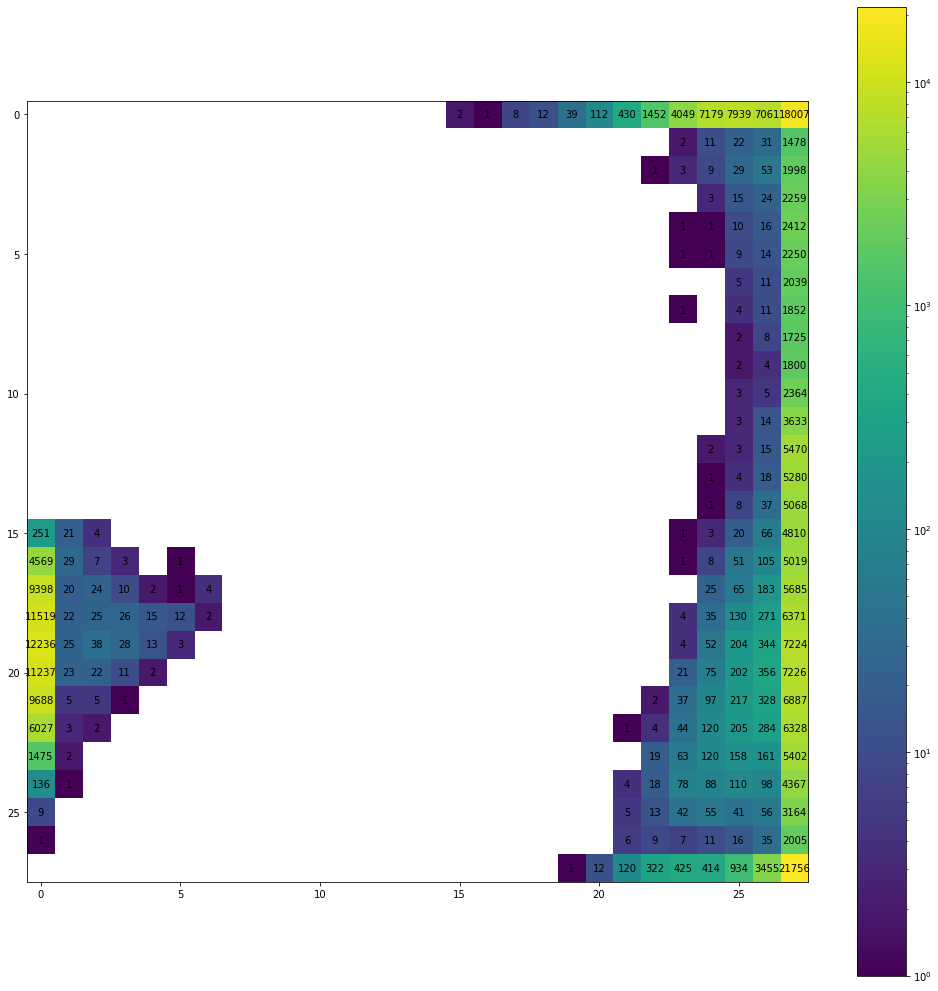

In [ ]:
Hitmap(som, abc) # abc -> dataset fortement bleu -> hitmap tres proche de blue_weights

## Tests

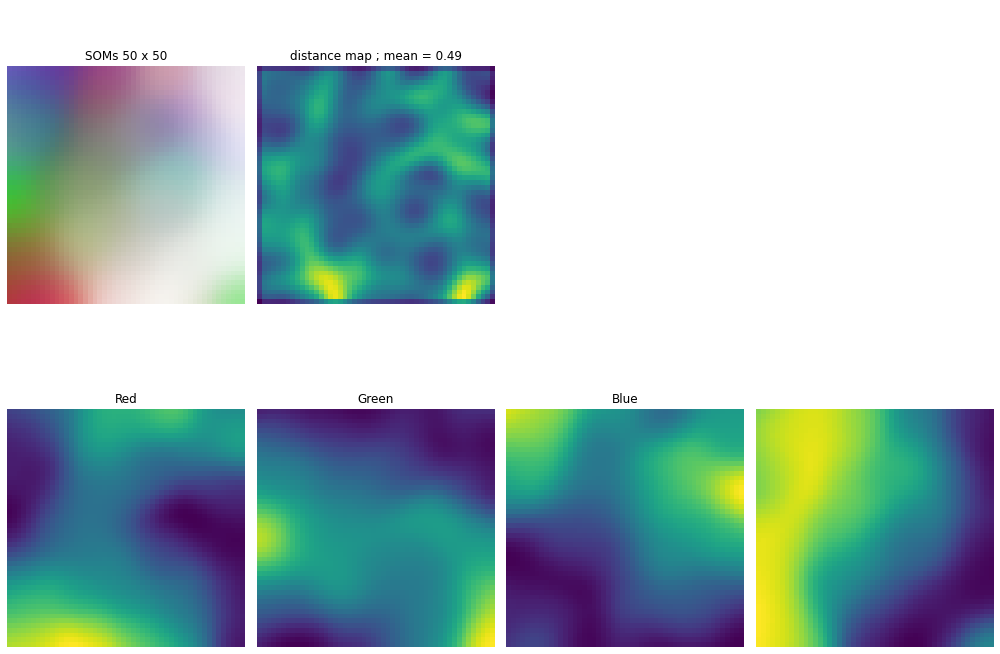

In [140]:
nb=250000
dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,dat2,dat3)).T


# normalize each row
sum_of_rows = data_color.sum(axis=1)
data_color_norm = data_color / sum_of_rows[:, np.newaxis]


# adding 4th column for the intensity
dat4 = np.random.uniform(0,1,nb)
#dat4 = np.random.normal(.5, .1, nb)
data_color = np.vstack((data_color_norm.T, dat4)).T


# SOMs
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

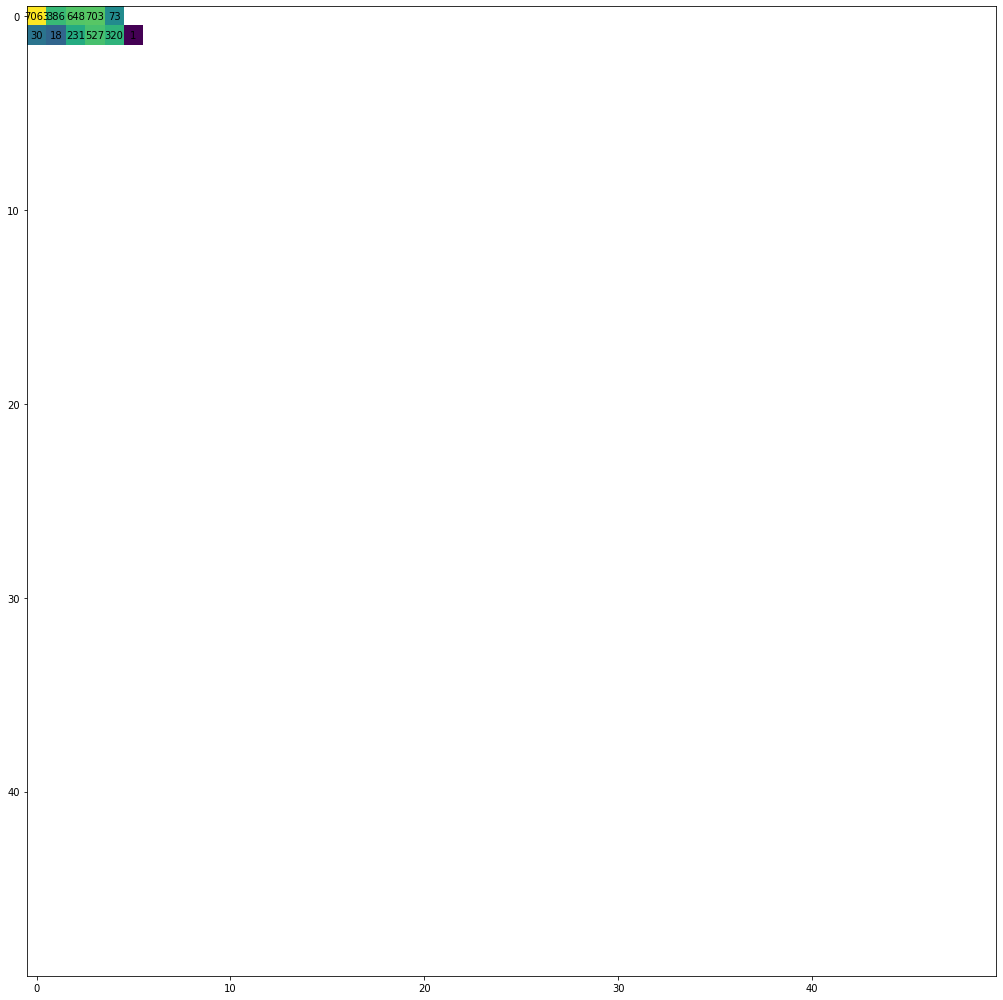

In [142]:
NB = 10000

a = np.random.uniform(0,.1,NB)
b = np.random.uniform(0,.1,NB)
c = np.random.normal(.8,.05,NB)

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc_norm = abc / sum_of_rows[:, np.newaxis]

# adding 4th column for the intensity
dat4 = np.random.uniform(0,.1,nb)
abc = np.vstack((abc_norm.T, d)).T
"""
a=np.ones(NB)
b=np.zeros(NB)
c=np.zeros(NB)
d=np.ones(NB)

abc = np.vstack((a,b,c,d)).T
"""
Hitmap(som, abc)

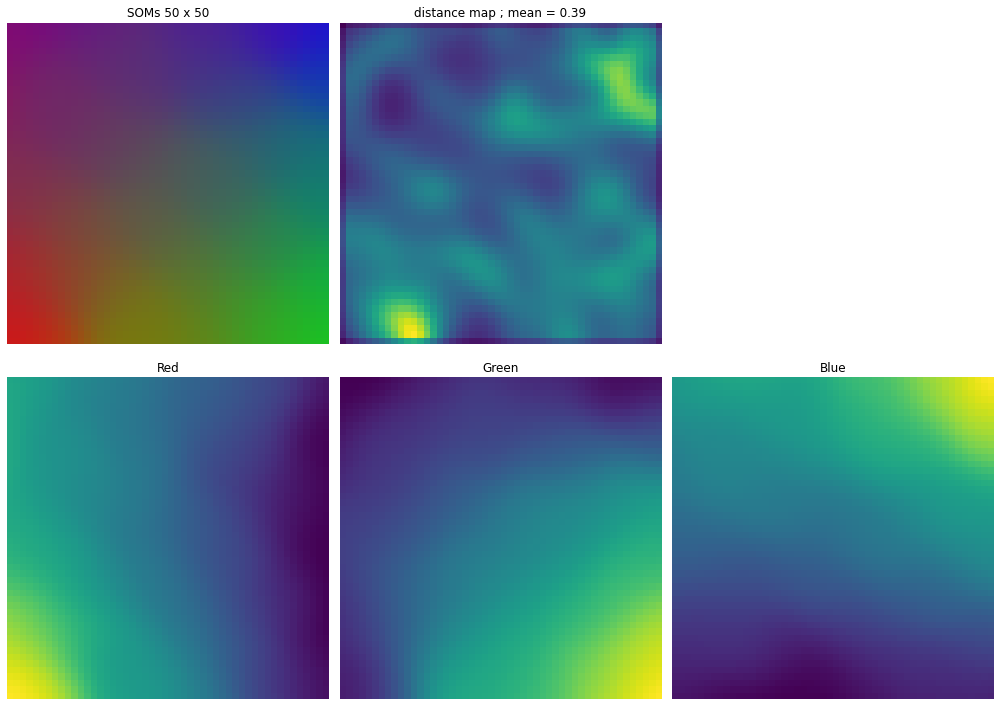

In [161]:
nb=250000
dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,dat2,dat3)).T


# normalize each row
sum_of_rows = data_color.sum(axis=1)
data_color = data_color / sum_of_rows[:, np.newaxis]


# adding 4th column for the intensity
#dat4 = np.random.uniform(0,1,nb)
#dat4 = np.random.normal(.5, .1, nb)
#data_color = np.vstack((data_color.T, dat4)).T


# SOMs
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

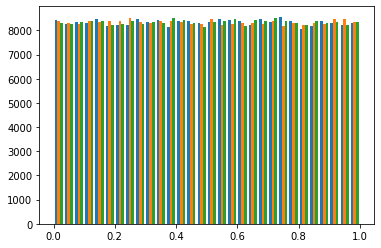

In [193]:
plt.hist(np.vstack((dat1,dat2,dat3)).T, bins=30);

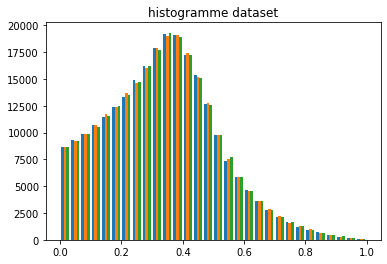

In [191]:
plt.title("histogramme dataset")
plt.hist(data_color, bins=30);

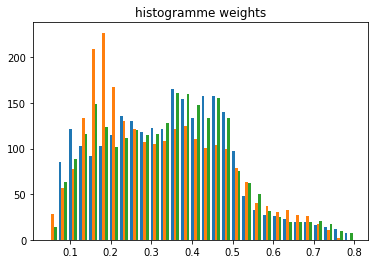

In [192]:
plt.title("histogramme weights")
plt.hist( weights.reshape( np.prod(weights.shape[0:2]) , 3), bins=30 );

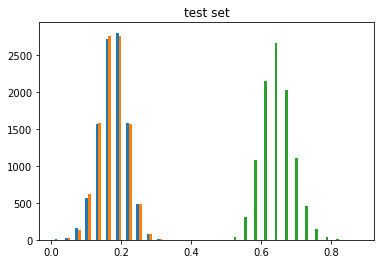

In [189]:
plt.title("test set")
plt.hist(abc,bins=30);

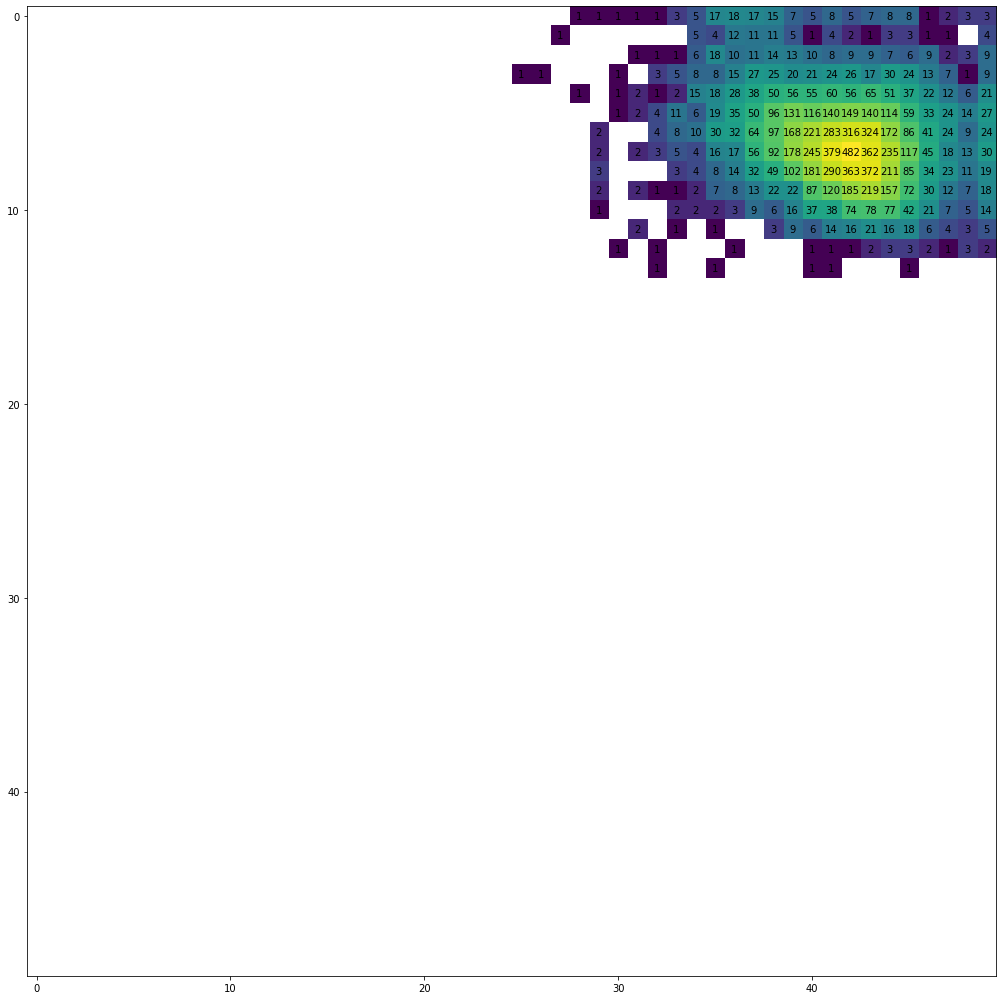

In [188]:
NB = 10000

#a = np.random.uniform(0,.1,NB)
#b = np.random.uniform(0,.1,NB)
a = np.random.normal(.2,.05,NB)
b = np.random.normal(.2,.05,NB)
c = np.random.normal(.7,.05,NB)

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc = abc / sum_of_rows[:, np.newaxis]

Hitmap(som, abc)

In [428]:
nb_test=10000

In [429]:
coord=[]
for i in range(nb_test):
    theta = np.random.uniform(np.pi)
    phi = np.random.uniform(np.pi*2)  

    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)  
    z = np.cos(theta)

    coord.append([x,y,z])

coord = np.abs(coord)

In [437]:
coord # normalisé en mode sqrt(x^2+...) -> pas bon

array([[0.65147305, 0.42511291, 0.62838036],
       [0.47418899, 0.88042124, 0.00180141],
       [0.10199556, 0.33986707, 0.93492635],
       ...,
       [0.23979225, 0.88800258, 0.39236602],
       [0.46848389, 0.12045054, 0.87522255],
       [0.57435757, 0.66236472, 0.48102636]])

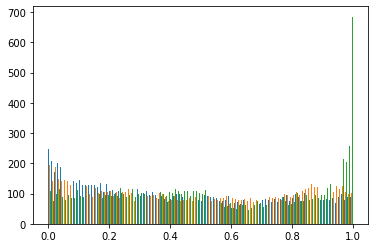

In [430]:
plt.hist(coord, bins=100);

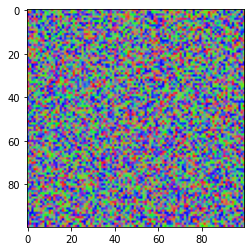

In [431]:
plt.imshow(coord.reshape(100,100,3));

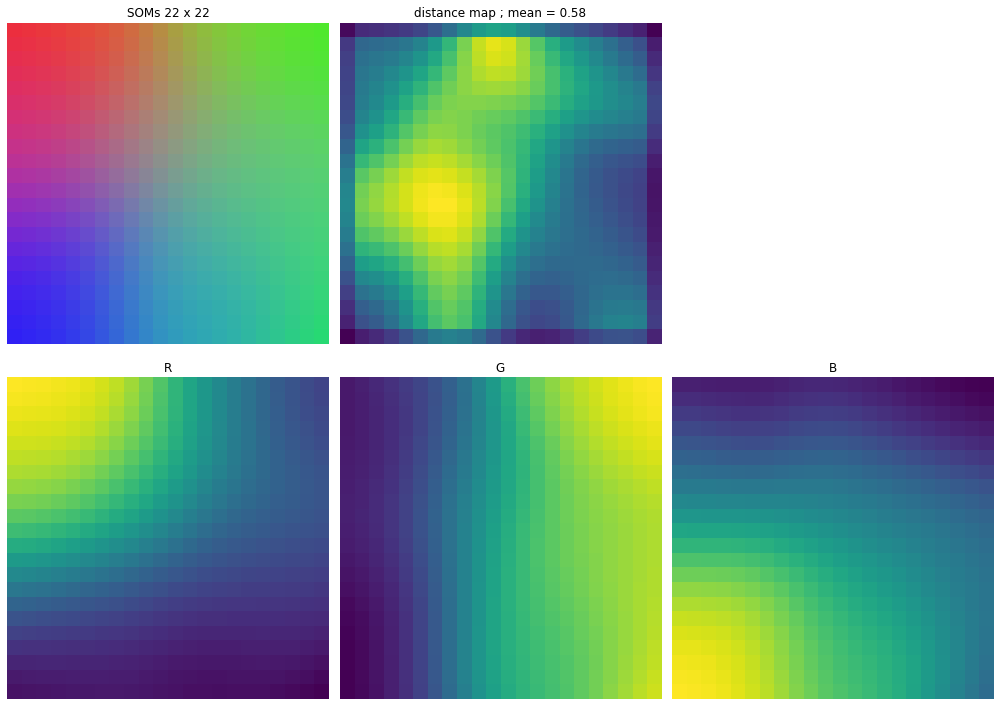

In [432]:
# SOMs
sigma = 7
learning_rate = 1

som_coord, weights_coord = train_som(coord, sigma, learning_rate, 5000)
som_color(coord, som_coord, weights_coord)

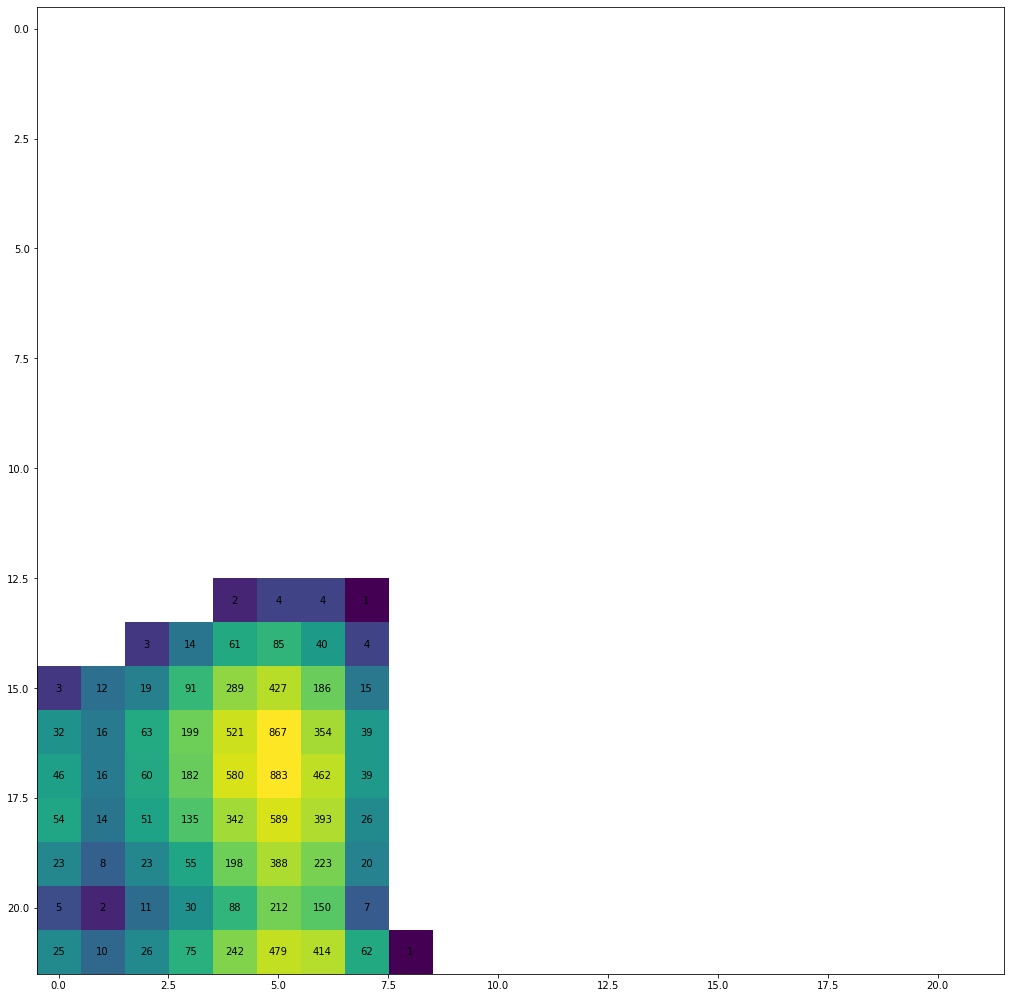

In [435]:
NB = 10000

#a = np.random.uniform(0,.1,NB)
#b = np.random.uniform(0,.1,NB)
a = np.random.normal(.2,.05,NB)
b = np.random.normal(.2,.05,NB)
c = np.random.normal(.7,.05,NB)

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc = abc / sum_of_rows[:, np.newaxis]

Hitmap(som_coord, abc)

## GHSOM

In [20]:
nb, data_color2, color_names = dat_color(more_dim=4)

som = GHSOM(data_color2, t1=0.3, t2=0.002, learning_rate=0.15, decay=0.9, gaussian_sigma=1.2)
ghsom = som.train()

print(ghsom)

[Elapsed Time: 0:00:42] |######################################| (25000/25000) 

position (0, 0) -- map dimensions (1, 1, 4) -- input dataset 25000 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 6722 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 1216 element(s) -- level 2 
			position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 409 element(s) -- level 3 
				position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 123 element(s) -- level 4 
				position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 103 element(s) -- level 4 
				position (1, 0) -- map dimensions (2, 2, 4) -- input dataset 83 element(s) -- level 4 
				position (1, 1) -- map dimensions (2, 2, 4) -- input dataset 100 element(s) -- level 4 
			position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 303 element(s) -- level 3 
				position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 74 element(s) -- level 4 
				position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 62 element(s) -- level 4

In [21]:
gmap = ghsom.child_map

In [22]:
gmap.weights_map[0]

array([[[0.77846813, 0.43356777, 0.72798239, 0.60219808],
        [0.23704735, 0.66069242, 0.73807975, 0.55338936]],

       [[0.59221745, 0.68137903, 0.21399368, 0.4710989 ],
        [0.3075462 , 0.28716483, 0.31162165, 0.40518167]]])

In [23]:
pos0_0 = gmap.neurons[0,0]
pos0_0

position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 6722 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 1216 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 409 element(s) -- level 2 
			position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 123 element(s) -- level 3 
			position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 103 element(s) -- level 3 
			position (1, 0) -- map dimensions (2, 2, 4) -- input dataset 83 element(s) -- level 3 
			position (1, 1) -- map dimensions (2, 2, 4) -- input dataset 100 element(s) -- level 3 
		position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 303 element(s) -- level 2 
			position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 74 element(s) -- level 3 
			position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 62 element(s) -- level 3 
			position (1, 0) -- map dimensions (2, 2, 4) -- input dataset 81 element(s) -- level 3 
			posit

In [24]:
pos0_0_0 = pos0_0.child_map.neurons[0,0]
pos0_0_0

position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 1216 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 409 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 123 element(s) -- level 2 
		position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 103 element(s) -- level 2 
		position (1, 0) -- map dimensions (2, 2, 4) -- input dataset 83 element(s) -- level 2 
		position (1, 1) -- map dimensions (2, 2, 4) -- input dataset 100 element(s) -- level 2 
	position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 303 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 74 element(s) -- level 2 
		position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 62 element(s) -- level 2 
		position (1, 0) -- map dimensions (2, 2, 4) -- input dataset 81 element(s) -- level 2 
		position (1, 1) -- map dimensions (2, 2, 4) -- input dataset 86 element(s) -- level 2 
	position (1, 0) -

In [25]:
pos0_0_0_0 = pos0_0_0.child_map.neurons[0,0]
pos0_0_0_0

position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 409 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 123 element(s) -- level 1 
	position (0, 1) -- map dimensions (2, 2, 4) -- input dataset 103 element(s) -- level 1 
	position (1, 0) -- map dimensions (2, 2, 4) -- input dataset 83 element(s) -- level 1 
	position (1, 1) -- map dimensions (2, 2, 4) -- input dataset 100 element(s) -- level 1 

In [131]:
pos0_0_0_0_all = pos0_0_0_0.child_map
pos0_0_0_0_all.weights_map

[array([[[0.67737571, 0.6170995 , 0.64346044, 0.37977994],
         [0.8989025 , 0.59464225, 0.60096822, 0.40929436]],
 
        [[0.63304015, 0.57342355, 0.88089777, 0.42442615],
         [0.86355669, 0.5451525 , 0.85949647, 0.45045671]]])]

In [31]:
pos0_0_0_0_0 = pos0_0_0_0.child_map.neurons[0,0]
pos0_0_0_0_0

position (0, 0) -- map dimensions (2, 2, 4) -- input dataset 123 element(s) -- level 0 

In [272]:
pos0_0_0_0_0._Neuron__weight_map

[array([[[0.67737571, 0.6170995 , 0.64346044, 0.37977994],
         [0.8989025 , 0.59464225, 0.60096822, 0.40929436]],
 
        [[0.63304015, 0.57342355, 0.88089777, 0.42442615],
         [0.86355669, 0.5451525 , 0.85949647, 0.45045671]]])]

In [246]:
lvl_0 = np.zeros((2,2),dtype=object)
lvl_1 = np.zeros((2,2),dtype=object)
lvl_2 = np.zeros((2,2),dtype=object)
lvl_3 = np.zeros((2,2),dtype=object)
tab_weights = []

idx1=0
for i in gmap.neurons.keys():
    lvl_0[i] = gmap.neurons[i]
    gmap_1 = lvl_0[i].child_map
    idx1+=1

    idx2=0
    for j in gmap_1.neurons.keys():
        lvl_1[j] = gmap.neurons[j]
        gmap_2 = lvl_1[j].child_map
        idx2+=1

        idx3=0
        for k in gmap_2.neurons.keys():
            lvl_2[k] = gmap.neurons[k]
            gmap_3 = lvl_2[k].child_map
            idx3+=1


            idx4=0
            for m in np.concatenate(gmap_3.weights_map[0]):
                idx4+=1
                tab_weights.append([idx1,idx2,idx3,idx4,m])

In [111]:
for i in gmap.neurons.keys():
    print(i)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


In [247]:
tab_weights = np.array(tab_weights)

In [248]:
tab_weights.shape

(256, 5)

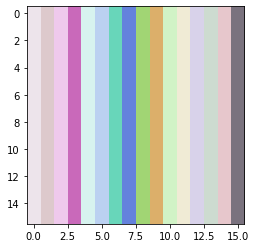

In [265]:
plt.imshow(np.concatenate(tab_weights[:,4]).reshape(16,16,4));

In [85]:
data_shape = 2
def __gmap_to_matrix(gmap):
    rows, cols = data_shape * np.array(gmap.shape[0:2])

    _image = np.empty(shape=(rows, cols), dtype=np.float32)

    for i in range(0, rows, data_shape):
        for j in range(0, cols, data_shape):
            neuron = gmap[i // data_shape, j // data_shape]
            _image[i:(i + data_shape), j:(j + data_shape)] = np.reshape(neuron, newshape=(data_shape, data_shape))
    return _image

In [82]:
def __plot_child(e, gmap, level):
    if e.inaxes is not None:
        coords = (int(e.ydata // data_shape), int(e.xdata // data_shape))
        neuron = gmap.neurons[coords]
        if neuron.child_map is not None:
            interactive_ghsom(neuron.child_map, num=str(coords), level=level+1)

In [83]:
def interactive_ghsom(gmap, num='root', level=1):
    _num = "level {} -- parent pos {}".format(level, num)
    fig, ax = plt.subplots(num=_num)
    ax.imshow(__gmap_to_matrix(gmap.weights_map), cmap='bone_r', interpolation='sinc')
    fig.canvas.mpl_connect('button_press_event', lambda event: __plot_child(event, gmap, level))
    plt.axis('off')
    fig.show()

5

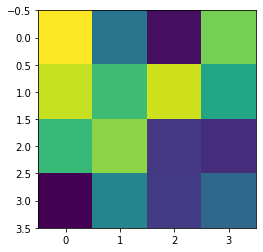

In [159]:
fig, ax = plt.subplots(1)
plt.imshow(__gmap_to_matrix(gmap.weights_map[0]))
fig.canvas.mpl_connect('button_press_event', lambda event: __plot_child(event, gmap, level))

<a name="S3_3"></a>
## Test hyperparams auto

In [ ]:
# finding the 2 parameters at the same time

rows = data_color.shape[0]
som_x = int(np.sqrt(5*np.sqrt(rows)))
som_y = som_x

space = {'sig' : hp.uniform('sig', som_x/10, som_x/2.01),
         'learnR' :hp.uniform('learnR', 0.001, 4)}

def som_fn(space):
    sig = space['sig']
    learnR = space['learnR']

    val = MiniSom(som_x, som_y,
                  data_color.shape[1],
                  sig,
                  learnR,
                  ).quantization_error(data_color)

    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best_params = fmin(
    fn = som_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 10,
    trials = trials
    )

sigma = best_params['sig']
learning_rate = best_params['learnR']

print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

100%|██████████| 10/10 [00:02<00:00,  3.78it/s, best loss: 0.23785618417138957]
sigma = 5.132646 ; learning rate 1.062127 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


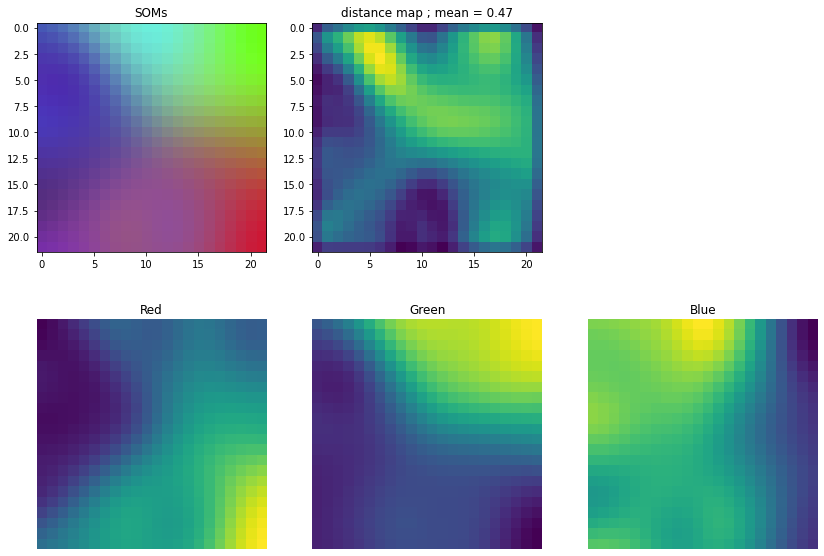

In [ ]:
print("sigma = %.2f ; learning rate %.2f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, sigma, learning_rate, 1000, verbose=False)
som_color(data_color, som, wts_color, color_names) # sigma = 9.263, learning_rate = 3.905

In [ ]:
# finding sigma only
rows = data_color.shape[0]
som_x = int(np.sqrt(5*np.sqrt(rows)))
som_y = som_x

learning_rate = 1

best_sig = fmin(
    fn = lambda sig : MiniSom(som_x,som_y,
                              data_color.shape[1],
                              sig,
                              learning_rate
                              ).quantization_error(data_color),
    space = hp.uniform("sig", som_x/10, som_x/2.01),
    algo = tpe.suggest,
    max_evals=200)

sigma = best_sig["sig"]
print(sigma)

100%|██████████| 200/200 [00:48<00:00,  4.12it/s, best loss: 0.23659006291835552]
8.762504662317241


sigma = 8.76 ; learning rate 1.00 



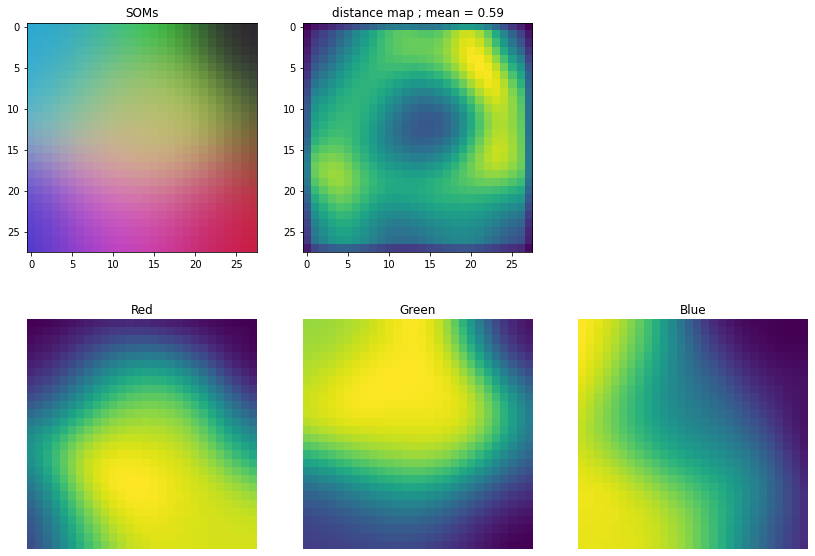

In [ ]:
print("sigma = %.2f ; learning rate %.2f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, sigma, learning_rate, 1000, verbose=False)
som_color(data_color, som, wts_color, color_names)

<a name="S4"></a>
# COSMOS dataset

## Loading datas

In [ ]:
from astropy.io import fits

path_CS_fits = "real_galaxy_catalog_25.2_fits.fits"

with fits.open(path_CS_fits) as hdul:
    hdr = hdul[0].header # header
    data_cs = hdul[1].data # data
    cols = hdul[1].columns # cols 
    Names_cs = cols.names # cols names

### Infos

In [ ]:
hdul.info()
Names_cs

Filename: real_galaxy_catalog_25.2_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   87798R x 14C   [J, D, D, D, 8D, 16D, 5J, D, D, D, J, J, 3D, 4D]   


['IDENT',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux']

In [ ]:
info_min_max(data_cs, Names_cs)

IDENT 

Max 1443979
Min 20

-------------------------------

mag_auto 

Max 1.0
Min 0.704704159505276

-------------------------------

flux_radius 

Max 56.62507247924805
Min 2.796747922897339

-------------------------------

zphot 

Max 0.9777937985249294
Min 0.0009244878030343573

-------------------------------

sersicfit 

Max 181.12170846645134
Min 0.0
---------
Max 0.9998641236334181
Min 0.0
---------
Max 0.9999999997486005
Min 0.016666666915019362
---------
Max 0.999085212018686
Min 0.05
---------
Max 0.0
Min 0.0
---------
Max 475.1418623367244
Min 0.23707499785345132
---------
Max 474.5236215113057
Min 0.0
---------
Max 3.139033454940841
Min -3.1258451514505134
---------

-------------------------------

bulgefit 

Max 203.13294121938745
Min -1.0
---------
Max 2611267.0105977356
Min -1.0
---------
Max 1.0
Min -1.0
---------
Max 2.24520986068672
Min -1.0
---------
Max 0.0
Min -1.0
---------
Max 475.120981973819
Min -1.0
---------
Max 474.4335253681926
Min -1.0
---------
Max 3.

## Making cuts...

### Half light radius cut and conversion :

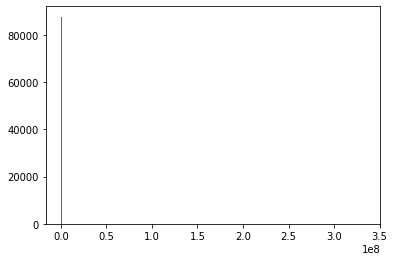

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

In [ ]:
def cut_hight_hlr(cat, lim): # delete hlr problems
    idx = np.where(cat['sersicfit'][:,1]>lim)[0]
    print("nb d'elements suppr", idx.shape)
    cat = np.delete(cat,idx)
    return cat

data_cs['sersicfit'][:,1] *= 0.03 # converting hlr

data_cs = cut_hight_hlr(data_cs, 1.4) # cut hight hlr values on the full catalog

nb d'elements suppr (3171,)


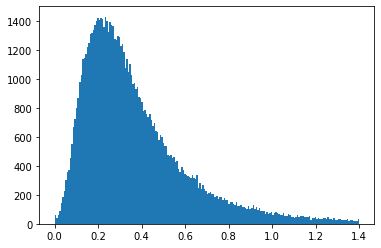

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

In [ ]:
data_cs['sersicfit'][:,1] /= max(data_cs['sersicfit'][:,1])

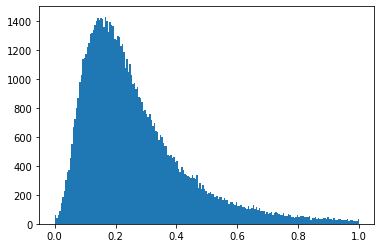

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

### Sersic normalization... and cuts

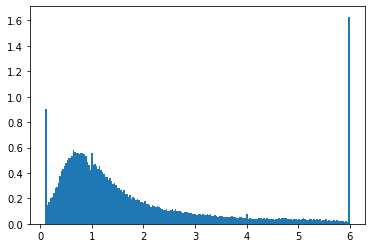

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
np.where(data_cs['sersicfit'][:,2]<0.11)[0].shape

(2063,)

In [ ]:
np.where(data_cs['sersicfit'][:,2]>5.99)[0].shape

(4032,)

In [ ]:
data_cs['sersicfit'][:,2] /= max(data_cs['sersicfit'][:,2]) # normalization

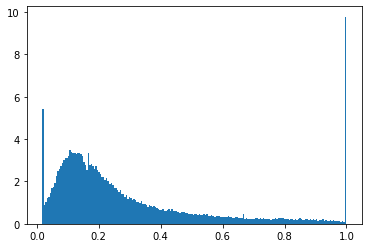

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,2] < 1 )[0] ]

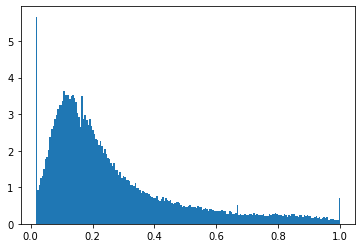

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,2] > min(data_cs['sersicfit'][:,2]) )[0] ]

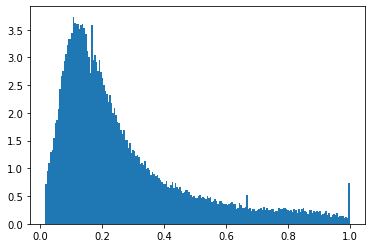

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

### q cut :

In [ ]:
np.where( data_cs['sersicfit'][:,3] > 1 )[0].shape

(14,)

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,3] < 1 )[0] ]

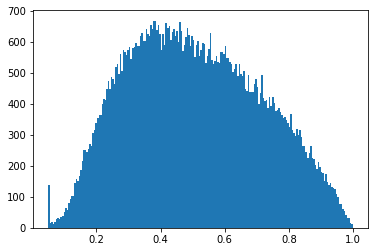

In [ ]:
plt.hist(data_cs['sersicfit'][:,3], bins=200);

In [ ]:
np.where( data_cs['sersicfit'][:,3] < 0.06 )[0].shape

(157,)

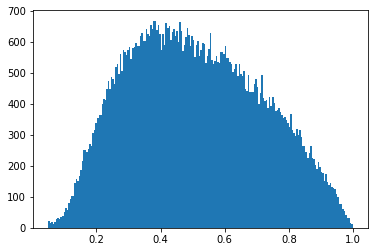

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,3] > 0.05 )[0] ]
plt.hist(data_cs['sersicfit'][:,3], bins=200);

### Intensity at the hlr :

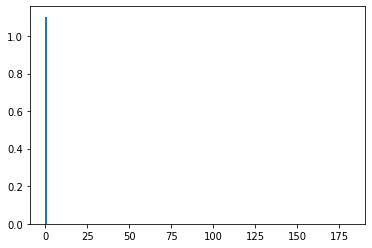

In [ ]:
plt.hist(data_cs['sersicfit'][:,0], bins=200, density=True);

In [ ]:
print(max(data_cs['sersicfit'][:,0]))
print(np.mean(data_cs['sersicfit'][:,0]))
print(min(data_cs['sersicfit'][:,0]))

181.12170846645134
0.07419850816778073
0.0


In [ ]:
np.where( data_cs['sersicfit'][:,0] > 0.3 )[0].shape

(331,)

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,0] < 0.3 )[0] ]

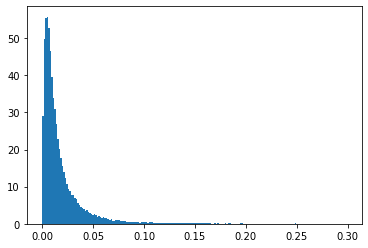

In [ ]:
plt.hist(data_cs['sersicfit'][:,0], bins=200, density=True);

In [ ]:
print(max(data_cs['sersicfit'][:,0]))
print(np.mean(data_cs['sersicfit'][:,0]))
print(min(data_cs['sersicfit'][:,0]))

0.29857793358805385
0.018726944985234334
0.0


### Magnitude

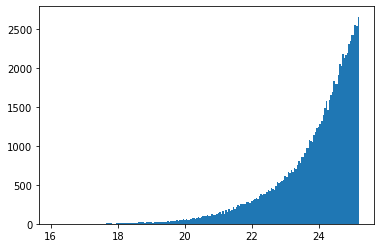

In [ ]:
plt.hist(data_cs['mag_auto'], bins=200);

In [ ]:
max(data_cs['mag_auto'])

25.19999122619629

In [ ]:
# magnitude
data_cs['mag_auto'] /= max(data_cs['mag_auto'])

# photometric redshift
#data_cs['zphot'] /= max(data_cs['zphot'])

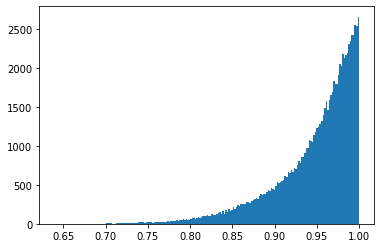

In [ ]:
plt.hist(data_cs['mag_auto'], bins=200);

## Selecting variables

In [ ]:
variables = ['magnitude', 
             'intensity at the hlr',
             'half_light_radius', 
             'Sersic',
             'q', 
             'photometric redshift',
             ]

caption = Label(value='Select some variables (at least 2)')
boxs = [Checkbox(description=i) for i in variables]

display(caption, *boxs)

Label(value='Select some variables (at least 2)')

Checkbox(value=False, description='magnitude')

Checkbox(value=False, description='intensity at the hlr')

Checkbox(value=False, description='half_light_radius')

Checkbox(value=False, description='Sersic')

Checkbox(value=False, description='q')

Checkbox(value=False, description='photometric redshift')

In [ ]:
Datas = [data_cs['mag_auto'],
         data_cs['sersicfit'][:,0],
         data_cs['sersicfit'][:,1],
         data_cs['sersicfit'][:,2],
         data_cs['sersicfit'][:,3],
         data_cs['zphot'],
         ]

dataset_i = []
vars_cs = []
cols = 0
for i in range(len(boxs)):
    if boxs[i].value==1:
        dataset_i.append(Datas[i])
        vars_cs.append(variables[i])
        cols += 1

assert cols>1, "pick at least 2 variables"

choice_cs = np.vstack([*dataset_i]).T


nb_cs = data_cs.shape[0] # rows number 
print("Nombre d'éléments :", nb_cs)
print("Selected variables :",vars_cs)

Nombre d'éléments : 87798
Selected variables : ['intensity at the hlr', 'Sersic']


## SOMs training and visualisation

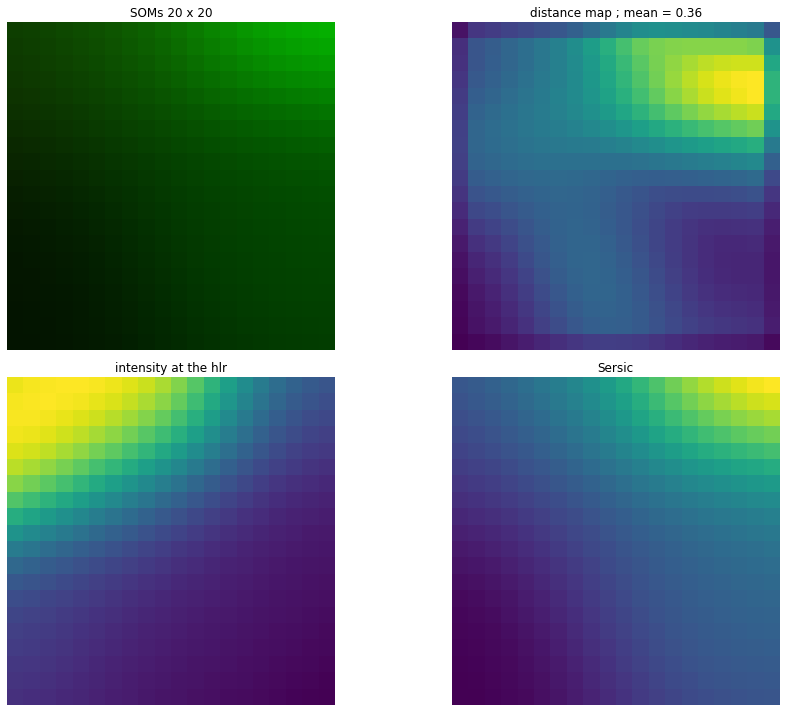

In [ ]:
sigma = 9
learning_rate = 1

som, weights = train_som(choice_cs, sigma, learning_rate, 1000, size=(20,20))
som_color(choice_cs, som, weights, vars_cs)

adding a dimension to the input


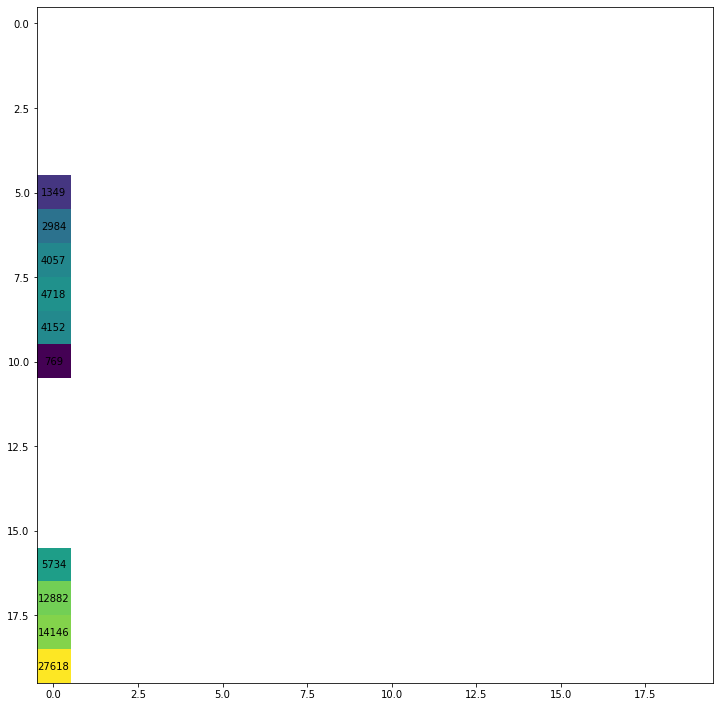

In [ ]:
#test = np.vstack([data_cs['sersicfit'][:,1], data_cs['mag_auto']]).T
#Hitmap(som, test, figsize=(10,10))

Hitmap(som, data_cs['sersicfit'][:,1], figsize=(10,10))

In [ ]:
interactive_plot(choice_cs, nb_cs, vars_cs)

interactive(children=(FloatSlider(value=9.0, description='sigma', max=18.0, min=1.0, step=0.5), FloatSlider(va…

<a name="S5"></a>
# TU dataset

In [ ]:
from astropy.io import fits

path_TU = "TU_created.fits"

with fits.open(path_TU) as hdul:
    hdr = hdul[0].header # header
    data_tu = hdul[1].data # data_tu
    cols = hdul[1].columns # cols
    Names_tu = cols.names # cols names

## Infos

In [ ]:
hdul.info()
Names_tu

Filename: TU_created.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   314709R x 6C   [D, D, D, D, D, D]   


['mag', 'half_light_radius', 'q', 'SSersic_n', 'PA', 'bt']

In [ ]:
info_min_max(data_tu, Names_tu)

mag 

Max 62.548
Min 15.5034

-------------------------------

half_light_radius 

Max 37.939921001861435
Min 0.001351005439189643

-------------------------------

q 

Max 1.0
Min 0.101

-------------------------------

SSersic_n 

Max 5.762576457449746
Min 0.24720666300706678

-------------------------------

PA 

Max 90.0
Min -90.0

-------------------------------

bt 

Max 1.0
Min 0.0

-------------------------------



## Cuts and normalizations

### Half light radius (cut only)

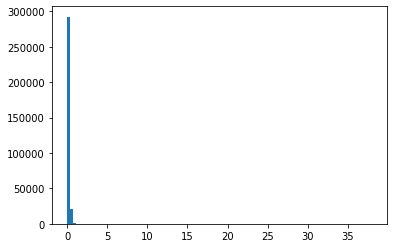

In [ ]:
plt.hist(data_tu['half_light_radius'], bins=100);

nombre d'elements suppr : 338


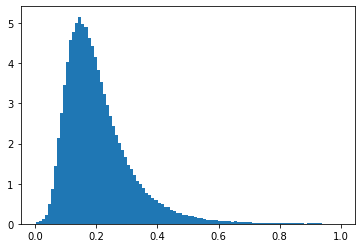

In [ ]:
hlr_sup1 = np.argwhere(data_tu['half_light_radius']>1) # suppression des elements de hlr > 1
print("nombre d'elements suppr :",len(hlr_sup1)) # nombre d'elements supprimes

data_tu = np.delete(data_tu, hlr_sup1)

plt.hist(data_tu['half_light_radius'], bins=100, density=True);

### Magnitude (cut and normalize)

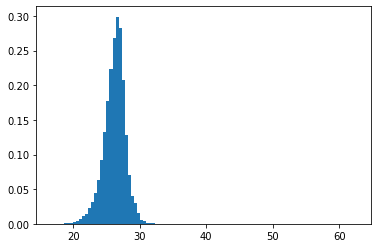

In [ ]:
plt.hist(data_tu['mag'], bins=100, density=True);

nombre d'elements suppr : 22


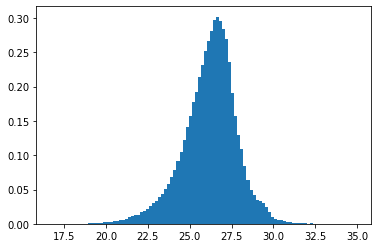

In [ ]:
mag_sup = np.argwhere(data_tu['mag']>35) # suppression des elements de mag > 40
print("nombre d'elements suppr :",len(mag_sup)) # nombre d'elements supprimes

data_tu = np.delete(data_tu, mag_sup)

plt.hist(data_tu['mag'], bins=100, density=True);

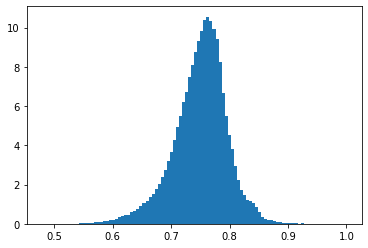

In [ ]:
data_tu['mag'] /= max(data_tu['mag'])# normalisation de mag pour le som

plt.hist(data_tu['mag'], bins=100, density=True);

### Sersic (normalize only)

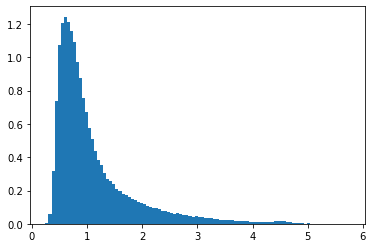

In [ ]:
plt.hist(data_tu['SSersic_n'], bins=100, density=True);

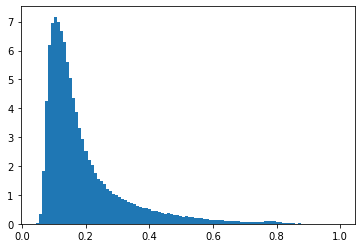

In [ ]:
data_tu['SSersic_n'] /= max(data_tu['SSersic_n'])

plt.hist(data_tu['SSersic_n'], bins=100, density=True);

## Selecting variables

In [ ]:
variables = Names_tu.copy()

caption = Label(value='Select some variables (at least 2)')
boxs = [Checkbox(description=i) for i in variables]

display(caption, *boxs)

Label(value='Select some variables (at least 2)')

Checkbox(value=False, description='mag')

Checkbox(value=False, description='half_light_radius')

Checkbox(value=False, description='q')

Checkbox(value=False, description='SSersic_n')

Checkbox(value=False, description='PA')

Checkbox(value=False, description='bt')

In [ ]:
dataset_i = []
vars_tu = []
cols = 0
for i in range(len(boxs)):
    if boxs[i].value==1:
        dataset_i.append(data_tu[Names_tu[i]])
        vars_tu.append(variables[i])
        cols += 1

assert cols>1, "pick at least 2 variables"

choice_tu = np.vstack([*dataset_i]).T

nb_tu = data_tu.shape[0] # rows number 
print("Nombre d'éléments :", nb_tu)
print("Selected variables :",vars_tu)

Nombre d'éléments : 314349
Selected variables : ['mag', 'half_light_radius', 'q', 'SSersic_n']


## SOMs training and visualisation

In [ ]:
interactive_plot(choice_tu, nb_tu, vars_tu)

interactive(children=(FloatSlider(value=13.0, description='sigma', max=25.0, min=1.0, step=0.5), FloatSlider(v…